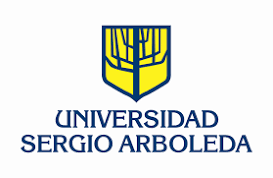

Udacity-cs344 HW2

Computación Paralela y distribuida

* Santiago Niño
* Esteban Rodriguez
* Daniel Velasquez

Abril 2023

In [ ]:
# Homework 2 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+https://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW2"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 144 (delta 14), reused 12 (delta 12), pack-reused 120
Receiving objects: 100% (144/144), 3.93 MiB | 26.16 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-mewv6p3u
  Running command git clone --filter=blob:none --quiet https://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-mewv6p3u
  Resolved https://github.com/depctg/nvcc4jupyter.git to commit 63b811d987446c2a3783845b7b85cda6e562b71a
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4333 sha256=b4bab7f9f2f3fc288a12c0b49f480eb0f6b458948b799a9e175846d44334e961
  Stored in directory: /tmp/pip-ephem-wheel-

In [ ]:
makefiletemp = open('../src/CMakeLists.txt','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[23] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../src/CMakeLists.txt','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../build/HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o.cmake','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[75] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../build/HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o.cmake','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../build/HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o.cmake.pre-gen','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[75] = "-Wno-deprecated-gpu-targets \n"

makefiletemp = open('../build/HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o.cmake.pre-gen','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
makefiletemp = open('../src/HW2/HW2.cpp','r+')
list_of_lines = makefiletemp.readlines()
list_of_lines[35] = "cv::Mat image = cv::imread(filename.c_str(), cv::IMREAD_COLOR); \n"
list_of_lines[41] = "cv::cvtColor(image, imageInputRGBA, cv::COLOR_BGR2RGBA); \n"
list_of_lines[109] = "cv::cvtColor(output, imageOutputBGR, cv::COLOR_RGBA2BGR); \n"

makefiletemp = open('../src/HW2/HW2.cpp','w')
makefiletemp.writelines(list_of_lines)
makefiletemp.close()

In [ ]:
%%writefile ../src/HW2/student_func.cu

//Homework 2
//Image Blurring

#include "utils.h"

__global__
void gaussian_blur(const unsigned char* const inputChannel,
                   unsigned char* const outputChannel,
                   int numRows, int numCols,
                   const float* const filter, const int filterWidth)
{

  const int2 thread_2D_pos = make_int2( blockIdx.x * blockDim.x + threadIdx.x,
                                        blockIdx.y * blockDim.y + threadIdx.y);
  if (thread_2D_pos.x >= numCols || thread_2D_pos.y >= numRows)
    return;

  const int hw = filterWidth / 2;
  float result = 0;
  for (int idx_x = 0; idx_x < filterWidth; idx_x ++) {
    for (int idx_y = 0; idx_y < filterWidth; idx_y ++) {
        int filter_idx = idx_y * filterWidth + idx_x;
        int image_x = min(max(idx_x + thread_2D_pos.x - hw, 0), static_cast<int>(numCols - 1));
        int image_y = min(max(idx_y + thread_2D_pos.y - hw, 0), static_cast<int>(numRows - 1));
        int pixel_idx = image_y * numCols + image_x;
        result += filter[filter_idx] * inputChannel[pixel_idx];
    }
  }

  outputChannel[thread_2D_pos.y * numCols + thread_2D_pos.x] = (unsigned char)result;

}

__global__
void separateChannels(const uchar4* const inputImageRGBA,
                      int numRows,
                      int numCols,
                      unsigned char* const redChannel,
                      unsigned char* const greenChannel,
                      unsigned char* const blueChannel)
{
  const int2 thread_2D_pos = make_int2( blockIdx.x * blockDim.x + threadIdx.x,
                                        blockIdx.y * blockDim.y + threadIdx.y);
  const int idx = thread_2D_pos.y * numCols + thread_2D_pos.x;

  if (thread_2D_pos.x >= numCols || thread_2D_pos.y >= numRows)
    return;

  const uchar4 pixel = inputImageRGBA[idx];
  redChannel[idx] = pixel.x;
  greenChannel[idx] = pixel.y;
  blueChannel[idx] = pixel.z;

}


__global__
void recombineChannels(const unsigned char* const redChannel,
                       const unsigned char* const greenChannel,
                       const unsigned char* const blueChannel,
                       uchar4* const outputImageRGBA,
                       int numRows,
                       int numCols)
{
  const int2 thread_2D_pos = make_int2( blockIdx.x * blockDim.x + threadIdx.x,
                                        blockIdx.y * blockDim.y + threadIdx.y);

  const int thread_1D_pos = thread_2D_pos.y * numCols + thread_2D_pos.x;


  if (thread_2D_pos.x >= numCols || thread_2D_pos.y >= numRows)
    return;

  unsigned char red   = redChannel[thread_1D_pos];
  unsigned char green = greenChannel[thread_1D_pos];
  unsigned char blue  = blueChannel[thread_1D_pos];

  //Alpha should be 255 for no transparency
  uchar4 outputPixel = make_uchar4(red, green, blue, 255);

  outputImageRGBA[thread_1D_pos] = outputPixel;
}

unsigned char *d_red, *d_green, *d_blue;
float         *d_filter;

void allocateMemoryAndCopyToGPU(const size_t numRowsImage, const size_t numColsImage,
                                const float* const h_filter, const size_t filterWidth)
{

  //allocate memory for the three different channels
  checkCudaErrors(cudaMalloc(&d_red,   sizeof(unsigned char) * numRowsImage * numColsImage));
  checkCudaErrors(cudaMalloc(&d_green, sizeof(unsigned char) * numRowsImage * numColsImage));
  checkCudaErrors(cudaMalloc(&d_blue,  sizeof(unsigned char) * numRowsImage * numColsImage));

  checkCudaErrors(cudaMalloc(&d_filter, sizeof(float) * filterWidth * filterWidth));

  checkCudaErrors(cudaMemcpy(d_filter, h_filter,
                             sizeof(float) * filterWidth * filterWidth,
                             cudaMemcpyHostToDevice));

}

void your_gaussian_blur(const uchar4 * const h_inputImageRGBA, uchar4 * const d_inputImageRGBA,
                        uchar4* const d_outputImageRGBA, const size_t numRows, const size_t numCols,
                        unsigned char *d_redBlurred,
                        unsigned char *d_greenBlurred,
                        unsigned char *d_blueBlurred,
                        const int filterWidth)
{
  //TODO: Set reasonable block size (i.e., number of threads per block)
  const dim3 blockSize(16, 16, 1);

  //TODO:
  //from the image size and and block size.
  const dim3 gridSize(
    numCols % 16 ? numCols / 16 + 1 : numCols / 16,
    numRows % 16 ? numRows / 16 + 1 : numRows / 16,
    1);

  separateChannels<<<gridSize,blockSize>>>(d_inputImageRGBA, numRows, numCols,
                            d_red, d_green, d_blue);

  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

  //TODO: Call your convolution kernel here 3 times, once for each color channel.
  gaussian_blur<<<gridSize, blockSize>>>(d_red, d_redBlurred,
                   numRows, numCols,
                   d_filter, filterWidth);
  gaussian_blur<<<gridSize, blockSize>>>(d_green, d_greenBlurred,
                   numRows, numCols,
                   d_filter, filterWidth);
  gaussian_blur<<<gridSize, blockSize>>>(d_blue, d_blueBlurred,
                   numRows, numCols,
                   d_filter, filterWidth);

  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

  recombineChannels<<<gridSize, blockSize>>>(d_redBlurred,
                                             d_greenBlurred,
                                             d_blueBlurred,
                                             d_outputImageRGBA,
                                             numRows,
                                             numCols);
  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
}


//Free all the memory that we allocated
void cleanup() {
  checkCudaErrors(cudaFree(d_red));
  checkCudaErrors(cudaFree(d_green));
  checkCudaErrors(cudaFree(d_blue));
  checkCudaErrors(cudaFree(d_filter));
}

Overwriting ../src/HW2/student_func.cu


In [ ]:
# make the cuda project
!Wno-deprecated-gpu-targets
!make HW2
print("\n====== RESULT OF HW2 =======\n")
!bin/HW2 ../src/HW2/cinque_terre.gold

/bin/bash: Wno-deprecated-gpu-targets: command not found
CMake Deprecation Warning at CMakeLists.txt:8 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


CMake Deprecation Warning at HW3/CMakeLists.txt:8 (cmake_minimum_required):
  Compatibility with CMake < 2.8.12 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- Configuring done
-- Generating done
-- Build files have been written to: /content/udacity-cs344-colab/build
[ 20%] Building NVCC (Device) object HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o
[ 40%] Building CXX object HW2/CMakeFiles/HW2.dir/main.cpp.o
[ 60%] Building CXX object HW2/CMakeFiles/HW2.dir/refer

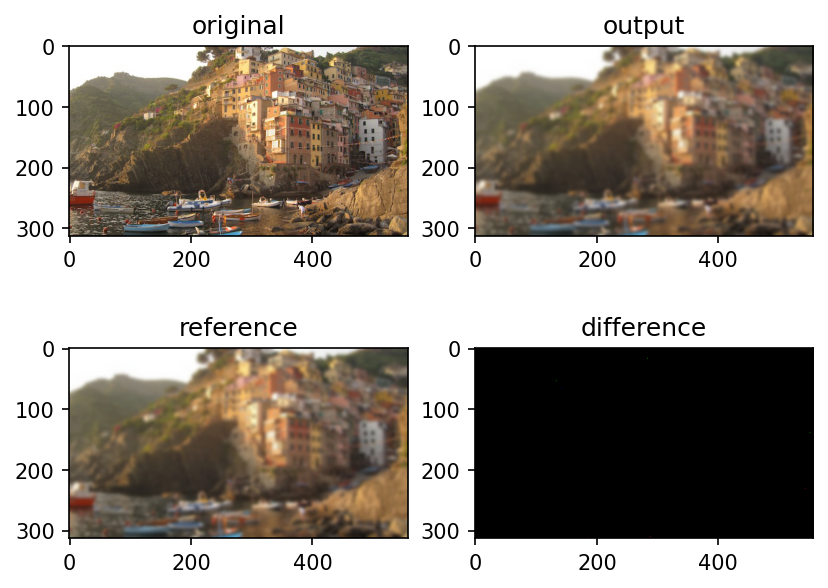

In [ ]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW1/cinque_terre_small.jpg"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW2_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW2_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW2_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()

Notas:
* Del archivo /content/udacity-cs344-colab/src/CMakeLists.txt, se cambió la linea 24 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/build/HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o.cmake, se cambió la linea 76 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/build/HW2/CMakeFiles/HW2.dir/HW2_generated_student_func.cu.o.cmake.pre-gen, se cambió la linea 76 por: -Wno-deprecated-gpu-targets
* Del archivo /content/udacity-cs344-colab/src/HW2/HW2.cpp, se cambió de la linea 36 CV_LOAD_IMAGE_COLOR por cv::IMREAD_COLOR
* Del archivo /content/udacity-cs344-colab/src/HW2/HW2.cpp, se cambió de la linea 42 CV_BGR2RGBA por cv::COLOR_BGR2RGBA
* Del archivo /content/udacity-cs344-colab/src/HW2/HW2.cpp, se cambió de la linea 110 CV_RGBA2BGR por cv::COLOR_RGBA2BGR